# Bias Types

In [2]:
from sklearn import model_selection
from ipynb.fs.full.Datasets import generateData_twoPills_2D, generateData_twoPills_noNoise_2D
from sklearn import svm
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt

In [2]:
colors = ['purple', 'teal', 'goldenrod', 'deepskyblue']
colormap = lambda x: [colors[int(xi)] for xi in x]

In [3]:
class BIASme:

    def __init__(self, bias_gen, data_gen, model = svm.SVC(kernel='linear')):
        self.model = model
        #self.model = svm.LinearSVR(max_iter=10000)

        # split the whole (unbiased) dataset into training and test set
        def splitTrainTest(test_size=0.30):
            X, Y = data_gen(10000)
            return model_selection.train_test_split(X, Y, test_size=test_size)

        # initialize splits, train unbiased model and add bias to the training set
        self.X_train, self.X_test, self.Y_train, self.Y_test = splitTrainTest()
        self.labels = list(set(self.Y_train))
        self.num_classes = len(self.labels)
        self.X_b_train, self.Y_b_train = bias_gen(self.X_train, self.Y_train)
        self.dims = len(self.X_b_train[0, :])
        if len(self.X_test[0, :]) > self.dims:
            self.X_test = self.X_test[:, 0:self.dims]
            self.X_train = self.X_train[:, 0:self.dims]

        if self.num_classes > 1:
            # compute initial accuracy on the unbiased test set
            biasedModel_init = self.model.fit(self.X_b_train, self.Y_b_train)
            self.acc_init = accuracy_score(biasedModel_init.predict(self.X_test), self.Y_test)

            # compute unbiased accuracy on the unbiased test set
            unbiasedModel_init = self.model.fit(self.X_train, self.Y_train)
            self.acc_unbiased = accuracy_score(unbiasedModel_init.predict(self.X_test), self.Y_test)
        else:
            self.acc_init = self.acc_unbiased = 1

    # evaluate the accuracy on the unbiased test set for the biased training set + a bunch of added points
    def accuracyBiased(self, addedPoints, addedLabels):
        biasedModel = self.model.fit(np.concatenate((self.X_b_train, addedPoints)),
                                     np.concatenate((self.Y_b_train, addedLabels)))
        return accuracy_score(biasedModel.predict(self.X_test), self.Y_test)

    # plot the biased data set to keep track of what happened
    def plotBias(self):
        # plot the biased data set
        isInB = np.array([int(elem) for elem in 
                          [self.X_train[i] in self.X_b_train for i in range(len(self.X_train))]])
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(2,2))
        plt.xticks([])
        plt.yticks([])
        #plt.title("Biased Dataset")
        plt.scatter(x=self.X_train[np.where(isInB == 0)[0]][:, 0], y=self.X_train[np.where(isInB == 0)[0]][:, 1],
                    c=colormap(self.Y_train[np.where(isInB == 0)[0]]), alpha=0.05, s=1)
        plt.scatter(x=self.X_train[np.nonzero(isInB)][:, 0], y=self.X_train[np.nonzero(isInB)][:, 1],
                    c=colormap(self.Y_train[np.nonzero(isInB)]), alpha=0.3, s=2)
        plt.show()
        return fig

In [4]:
def bias_chess_2D(training, labels, mode='24'):
    d_mean = np.mean(training, axis=0)
    d = training - d_mean
    
    sign = 1 if mode=='24' else -1
    X_b = training[np.sign(d[:,0]) * np.sign(d[:,1]) == sign]
    Y_b = labels[np.sign(d[:,0]) * np.sign(d[:,1]) == sign]
    
    return X_b, Y_b

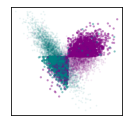

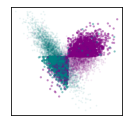

In [11]:
#bias_gen = lambda a, b: bias_chess_2D(training=a, labels=b)
#B = BIASme(bias_gen, data_gen=generateData_twoPills_2D)
#B.plotBias()

In [7]:
# prob = probability that data in the biased zone remains
def bias_rotate_2D(training, labels, alpha=np.pi, biasedClass=0, prob=0.05):
    alpha = (alpha % (2*np.pi)) if alpha > 2*np.pi else alpha
    classMean = training[labels == biasedClass].mean(0)

    rnd = np.random.rand(len(labels))
    d = np.sqrt((training[:, 0] - classMean[0]) ** 2 + (training[:, 1] - classMean[1]) ** 2)
    angles = np.arcsin((training[:, 1] - classMean[1]) / d)
    angles = np.array(
        [(np.pi - angles[i] if training[:, 0][i] < classMean[0] else angles[i]) for i in range(len(angles))])
    angles = np.array([(2 * np.pi + angles[i] if angles[i] < 0 else angles[i]) for i in range(len(angles))])
    if alpha >= np.pi:
        biasArea = np.logical_or(angles > alpha, angles < alpha - np.pi)
    else:
        biasArea = np.logical_and(angles > alpha, angles < (alpha + np.pi) % (2 * np.pi))
    biasArea = np.logical_and(biasArea, labels == biasedClass)

    X_b = training[np.logical_or(biasArea == False, rnd < prob)]
    Y_b = labels[np.logical_or(biasArea == False, rnd < prob)]
    return X_b, Y_b

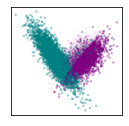

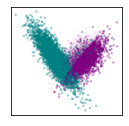

In [7]:
#bias_gen = lambda a, b: bias_rotate_2D(training=a, labels=b, alpha=0.25*np.pi, biasedClass=0)
#B = BIASme(bias_gen, data_gen=generateData_twoPills_2D)
#B.plotBias()

In [8]:
def bias_rotate_double_2D(training, labels, alphas=[np.pi], classes=[0]):
    X_b = training
    Y_b = labels
    for i in range(len(alphas)):
        alpha = alphas[i]
        X_b, Y_b = bias_rotate_2d(X_b, Y_b, alphas[i], classes[i])
    return X_b, Y_b

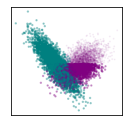

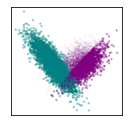

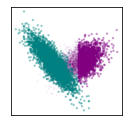

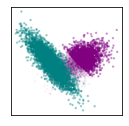

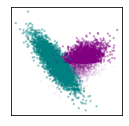

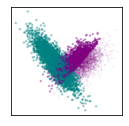

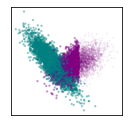

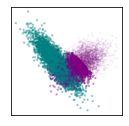

In [9]:
# generates plots that show the rotated bias
#angles = [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75]
#data_gen = generateData_twoPills_noNoise_2D
#for alpha in angles:
#    bias_gen = lambda a, b: bias_rotate_2D(training=a, labels=b, alpha=alpha*np.pi, biasedClass=0, prob=0)
#    b = BIASme(bias_gen, data_gen)
#    fig = b.plotBias()
#    s = 'Results/Exp_synth_angles_' + str(alpha) + '.pdf'
#    fig.savefig(s, format='pdf', dpi=1200, bbox_inches='tight')